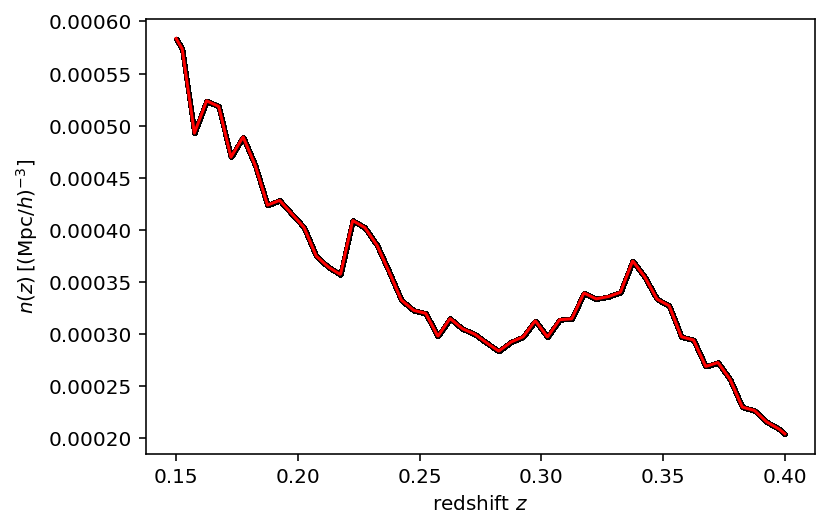

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import InterpolatedUnivariateSpline
import fitsio
%config InlineBackend.figure_format = 'retina'

zmin, zmax = 0.15, 0.4


data_dir = '/pscratch/sd/e/epaillas/dsl-lowz'
data_fn = Path(data_dir) / 'galaxy_DR12v5_LOWZ_North.fits.gz'
data_lowz = fitsio.read(data_fn, columns=['Z', 'NZ'])
mask = (data_lowz['Z'] > zmin) & (data_lowz['Z'] < zmax)
data_lowz = data_lowz[mask]

idx_unique = np.unique(data_lowz['Z'], return_index=True)[1]
data_lowz = data_lowz[idx_unique]

sort_idx = np.argsort(data_lowz['Z'])

data_lowz = data_lowz[sort_idx]

# normalize such that the maximum is 1
# data_lowz['NZ'] /= np.max(data_lowz['NZ'])

nz_spline = InterpolatedUnivariateSpline(data_lowz['Z'], data_lowz['NZ'], k=1)

cout = np.c_[np.linspace(zmin, zmax, 1000), nz_spline(np.linspace(zmin, zmax, 1000))]

np.savetxt('/pscratch/sd/e/epaillas/dsl-lowz/nz_lowz.txt', cout, fmt='%.5f', header='z   n(z)')

fig, ax = plt.subplots()

ax.scatter(data_lowz['Z'], data_lowz['NZ'], s=1, color='k')
z = np.linspace(zmin, zmax, 1000)
ax.plot(z, nz_spline(z), color='r')

ax.set_xlabel('redshift 'r'$z$')
ax.set_ylabel(r'$n(z)\, [({\rm Mpc}/h)^{-3}]$')



plt.show()

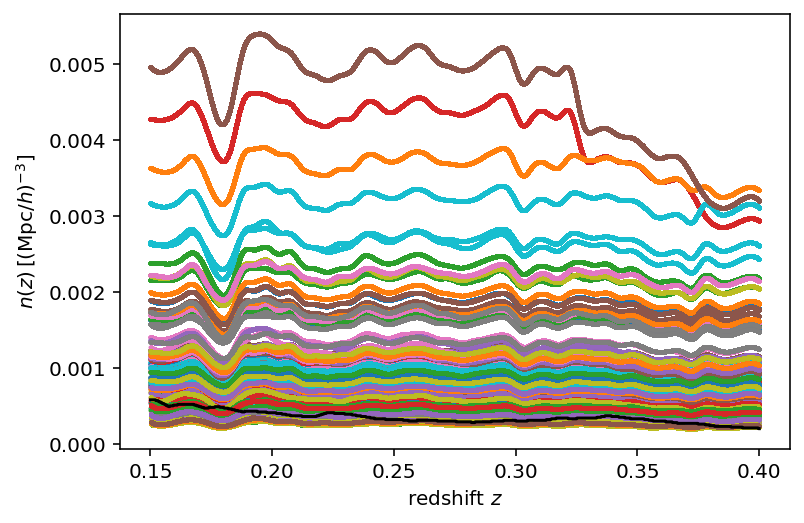

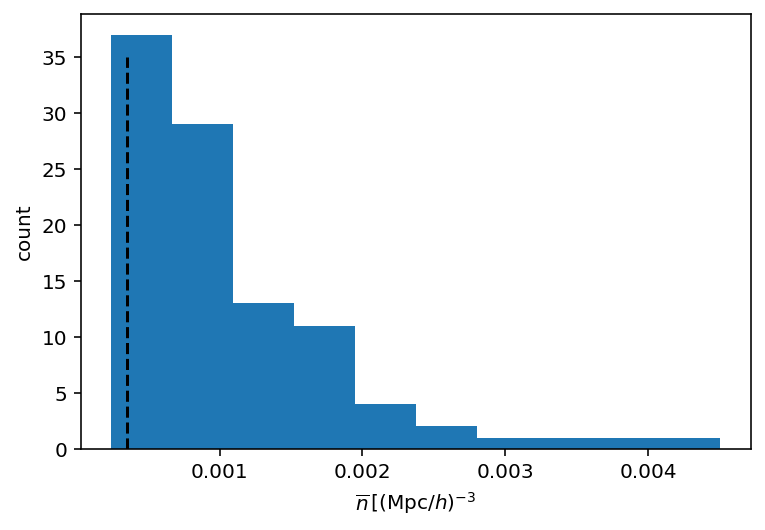

In [8]:
cosmo = 0
fig, ax = plt.subplots()

nbar = []
for hod in range(0, 100):
    data_dir = f'/pscratch/sd/e/epaillas/summit_lightcones/HOD/LOWZ/LRG/vanilla/c{cosmo:03}_ph000/complete/'
    data_fn = Path(data_dir) / f'AbacusSummit_lightcone_c{cosmo:03}_ph000_hod{hod:03}.npy'
    data = np.load(data_fn, allow_pickle=True).item()

    # ax.scatter(data['Z'], data['NZ']/data['NZ'].max(), s=1,)
    ax.scatter(data['Z'], data['NZ'], s=1,)
    nbar.append(data['NZ'].mean())


data_fn = "/pscratch/sd/e/epaillas/dsl-lowz/nz_lowz.txt"
data = np.genfromtxt(data_fn, skip_header=1)
z = data[:, 0]
nz = data[:, 1]
nz_spline = InterpolatedUnivariateSpline(z, nz, k=1)
ax.plot(z, nz_spline(z), color='k')
# ax.plot(z, nz_spline(z)/nz_spline(z).max(), color='k')

ax.set_xlabel('redshift 'r'$z$')
ax.set_ylabel(r'$n(z)\, [({\rm Mpc}/h)^{-3}]$')
plt.show()

fig, ax = plt.subplots()
ax.hist(nbar,)
ax.vlines(nz_spline(z).mean(), 0, 35, color='k', linestyle='--')
ax.set_xlabel(r'$\overline{n}\, [({\rm Mpc}/h)^{-3}$')
ax.set_ylabel(r'count')
plt.show()

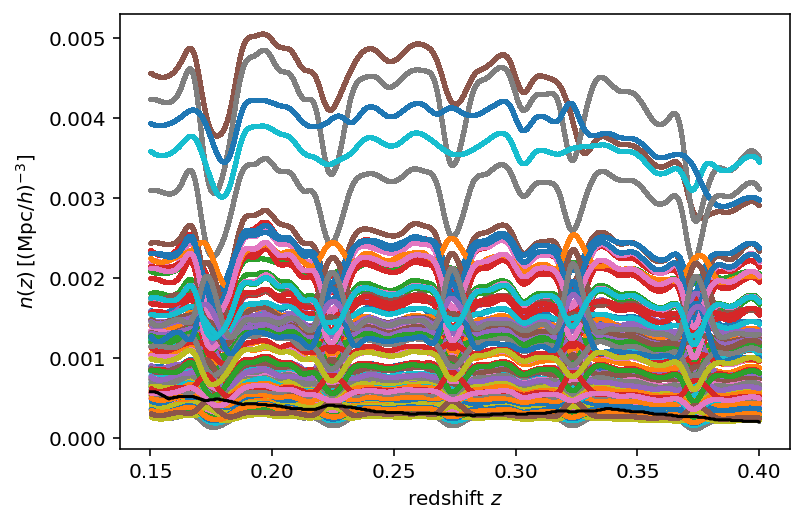

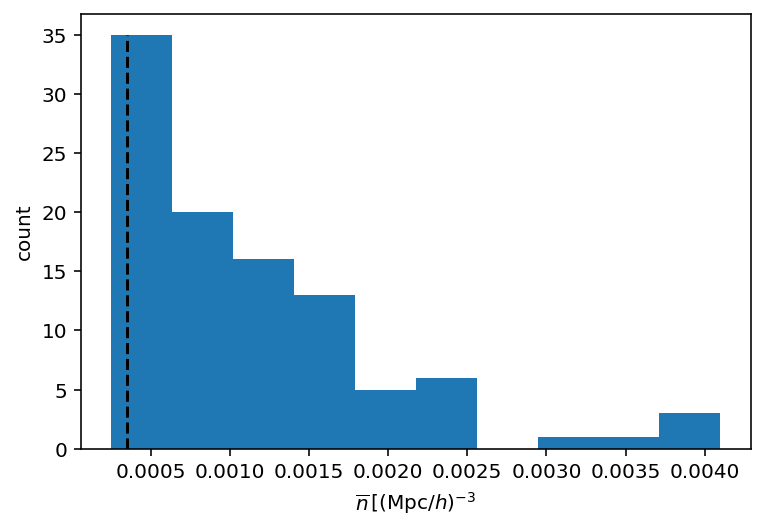

In [9]:
cosmo = 0
fig, ax = plt.subplots()

nbar = []
for hod in range(0, 100):
    data_dir = f'/pscratch/sd/e/epaillas/summit_lightcones/HOD/LOWZ/LRG/baseline/c{cosmo:03}_ph000/complete/'
    data_fn = Path(data_dir) / f'AbacusSummit_lightcone_c{cosmo:03}_ph000_hod{hod:03}.npy'
    data = np.load(data_fn, allow_pickle=True).item()

    # ax.scatter(data['Z'], data['NZ']/data['NZ'].max(), s=1,)
    ax.scatter(data['Z'], data['NZ'], s=1,)
    nbar.append(data['NZ'].mean())


data_fn = "/pscratch/sd/e/epaillas/dsl-lowz/nz_lowz.txt"
data = np.genfromtxt(data_fn, skip_header=1)
z = data[:, 0]
nz = data[:, 1]
nz_spline = InterpolatedUnivariateSpline(z, nz, k=1)
ax.plot(z, nz_spline(z), color='k')
# ax.plot(z, nz_spline(z)/nz_spline(z).max(), color='k')

ax.set_xlabel('redshift 'r'$z$')
ax.set_ylabel(r'$n(z)\, [({\rm Mpc}/h)^{-3}]$')
plt.show()

fig, ax = plt.subplots()
ax.hist(nbar,)
ax.vlines(nz_spline(z).mean(), 0, 35, color='k', linestyle='--')
ax.set_xlabel(r'$\overline{n}\, [({\rm Mpc}/h)^{-3}$')
ax.set_ylabel(r'count')
plt.show()

0.15118217676422332


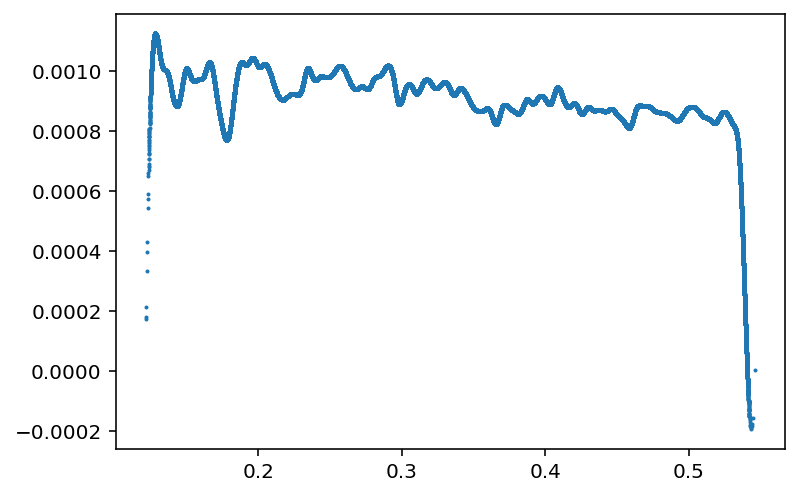

None


In [47]:
from cosmoprimo.fiducial import AbacusSummit

def downsample(data, target_nz):
    idx_accept = []
    for i in range(0, len(data)):
        rnd_num = np.random.uniform(0, 1)
        if rnd_num < target_nz(data['Z'][i]):
            idx_accept.append(i)
    return idx_accept

def spl_nofz(zarray, fsky, cosmo, zmin, zmax, Nzbins=100):
    zbins = np.linspace(zmin, zmax, Nzbins+1)
    Nz, zbins = np.histogram(zarray, zbins)
    zmid = zbins[0:-1] + (zmax-zmin)/Nzbins/2.0
    zmid[0], zmid[-1] = zbins[0], zbins[-1]
    rmin = cosmo.comoving_radial_distance(zbins[0:-1])
    rmax = cosmo.comoving_radial_distance(zbins[1:])
    vol = fsky * 4./3*np.pi * (rmax**3.0 - rmin**3.0)
    nz_array = Nz/vol
    spl_nz = InterpolatedUnivariateSpline(zmid, nz_array)
    return spl_nz


data_dir = '/pscratch/sd/e/epaillas/summit_lightcones/HOD/LOWZ/LRG/testprior'
data_fn = Path(data_dir) / f'AbacusSummit_lightcone_c000_ph000_hod0.npy'
data = np.load(data_fn, allow_pickle=True).item()

fig, ax = plt.subplots()
ax.scatter(data['Z'], data['NZ'], s=1,)
plt.show()

downsampled_idx = downsample(data, nz_spline)

downsampled_data = data.copy()
downsampled_data['Z'] = data['Z'][downsampled_idx]

cosmo = AbacusSummit(0)
fsky = 1 / 8
spl_nz = spl_nofz(downsampled_data['Z'], fsky, cosmo, zmin, zmax, Nzbins=100)
downsampled_data['NZ'] = spl_nz(downsampled_data['Z'])
